In [2]:
!pip install qutip


/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


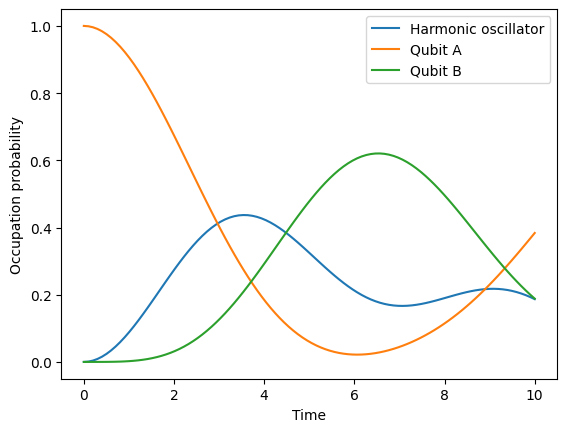

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define parameters
N = 5  # Number of Fock states for the harmonic oscillator
wc = 0.5 * 2 * np.pi  # Frequency of the harmonic oscillator
wa = 1.0 * 2 * np.pi  # Frequency of qubit A
wb = 1.1 * 2 * np.pi  # Frequency of qubit B
g = 0.05 * 2 * np.pi  # Coupling strength

# Define operators
a = tensor(destroy(N), qeye(2), qeye(2))
sm_a = tensor(qeye(N), destroy(2), qeye(2))
sm_b = tensor(qeye(N), qeye(2), destroy(2))

# Hamiltonian for the system
H0 = wc * a.dag() * a + 0.5 * wa * sm_a.dag() * sm_a + 0.5 * wb * sm_b.dag() * sm_b
H_int = g * (a * sm_a.dag() + a.dag() * sm_a) + g * (a * sm_b.dag() + a.dag() * sm_b)
H = H0 + H_int

# Collapse operators
c_ops = [np.sqrt(0.1) * a]

# Initial state: qubit A in the excited state, qubit B in the ground state, oscillator in the ground state
psi0 = tensor(basis(N,0), basis(2,1), basis(2,0))

# Time evolution
tlist = np.linspace(0, 10, 100)
result = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm_a.dag() * sm_a, sm_b.dag() * sm_b])
# Plot results
plt.plot(tlist, result.expect[0], label='Harmonic oscillator')
plt.plot(tlist, result.expect[1], label='Qubit A')
plt.plot(tlist, result.expect[2], label='Qubit B')
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.legend()
plt.show()


In [ ]:
tlist.shape, reconstruction_error.shape, reconstructed_data.shape

((100,), (3,), (100, 3))

Using neural networks to predict the dynamics of a quantum system

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.1650 - val_loss: 1.0009
Epoch 2/100
1/1 [==============================] - 0s 57ms/step - loss: 1.0647 - val_loss: 1.0018
Epoch 3/100
1/1 [==============================] - 0s 72ms/step - loss: 1.0687 - val_loss: 1.0028
Epoch 4/100
1/1 [==============================] - 0s 55ms/step - loss: 1.0981 - val_loss: 1.0039
Epoch 5/100
1/1 [==============================] - 0s 65ms/step - loss: 1.0414 - val_loss: 1.0050
Epoch 6/100
1/1 [==============================] - 0s 77ms/step - loss: 0.9987 - val_loss: 1.0062
Epoch 7/100
1/1 [==============================] - 0s 53ms/step - loss: 0.9991 - val_loss: 1.0074
Epoch 8/100
1/1 [==============================] - 0s 88ms/step - loss: 1.0270 - val_loss: 1.0087
Epoch 9/100
1/1 [==============================] - 0s 99ms/step - loss: 1.0343 - val_loss: 1.0099
Epoch 10/100
1/1 [==============================] - 0s 54ms/step - loss: 1.0386 - val_loss: 1.0111
Epoch 11/100
1/1 [===

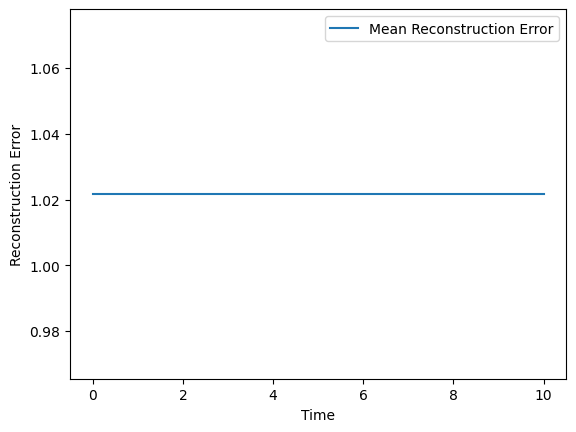

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

# Time evolution simulation
tlist = np.linspace(0, 10, 100)
result = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm_a.dag() * sm_a, sm_b.dag() * sm_b])

# Extract the time evolution data
data = np.array([result.expect[0], result.expect[1], result.expect[2]])

# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data.T).T

# Create training and test sets
X_train, X_test = train_test_split(data_standardized, test_size=0.2, random_state=42)

# Build an autoencoder model
input_dim = X_train.shape[1]
# Create the model
model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dropout(0.2),  # Add dropout with 20% dropout rate
    Dense(4, activation='relu'),
    Dropout(0.2),  # Add dropout with 20% dropout rate
    Dense(8, activation='relu'),
    Dropout(0.2),  # Add dropout with 20% dropout rate
    Dense(input_dim, activation='tanh')
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the autoencoder on the normal behavior (training set)
model.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Reshape the input data for prediction
data_standardized_reshaped = data_standardized.T.reshape(-1, len(tlist))

# Reconstruct the data using the trained autoencoder
reconstructed_data_reshaped = model.predict(data_standardized_reshaped)

# Reshape the reconstructed data back to the original shape
reconstructed_data = reconstructed_data_reshaped.T

# Calculate the reconstruction error
reconstruction_error = np.mean(np.square(data_standardized.T - reconstructed_data), axis=0)
# Calculate the mean reconstruction error across all features
mean_reconstruction_error = np.mean(reconstruction_error)

# Plot the mean reconstruction error over time
plt.plot(tlist, np.full_like(tlist, mean_reconstruction_error), label='Mean Reconstruction Error')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


In [70]:
data_m = np.array(data)

In [71]:
reconstr_m = np.array(reconstructed_data).T

In [57]:
reconstr_m[0].shape

(100,)

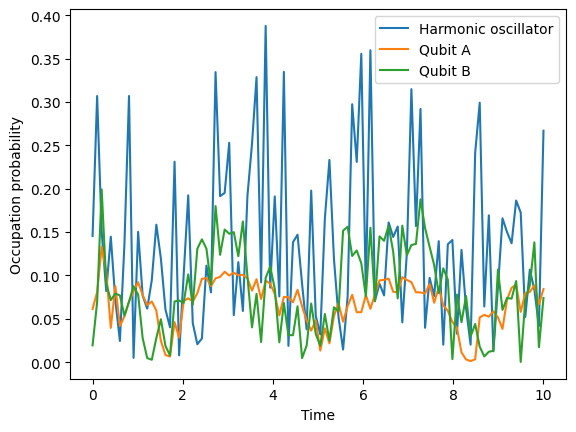

In [72]:
# Plot results
plt.plot(tlist, abs(reconstr_m[0]), label='Harmonic oscillator')
plt.plot(tlist, abs(reconstr_m[1]), label='Qubit A')
plt.plot(tlist, abs(reconstr_m[2]), label='Qubit B')
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.legend()
plt.show()

# Compute the mean squared error (MSE) between the original and reconstructed data


In [73]:
mse = np.mean((data_m - reconstr_m)**2)


In [74]:
mse

0.15143682426964153

The anomaly detection -> coupling parameter

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Define parameters
N = 5  # Number of Fock states for the harmonic oscillator
wc = 0.5 * 2 * np.pi  # Frequency of the harmonic oscillator
wa = 1.0 * 2 * np.pi  # Frequency of qubit A
wb = 1.1 * 2 * np.pi  # Frequency of qubit B

# Define operators
a = tensor(destroy(N), qeye(2), qeye(2))
sm_a = tensor(qeye(N), destroy(2), qeye(2))
sm_b = tensor(qeye(N), qeye(2), destroy(2))

# Initialize arrays to store time-evolution data
tlist = np.linspace(0, 10, 100)
data_normal = []
data_anomaly = []

# Normal behavior: constant coupling strength
g_normal = 0.05 * 2 * np.pi

# Anomalous behavior: sudden change in coupling strength
g_anomaly = 0.1 * 2 * np.pi

# Generate data
for g_value in [g_normal, g_anomaly]:
    H_int = g_value * (a * sm_a.dag() + a.dag() * sm_a) + g_value * (a * sm_b.dag() + a.dag() * sm_b)
    H = wc * a.dag() * a + 0.5 * wa * sm_a.dag() * sm_a + 0.5 * wb * sm_b.dag() * sm_b + H_int
    result = mesolve(H, tensor(basis(N,0), basis(2,1), basis(2,0)), tlist, [], [a.dag() * a, sm_a.dag() * sm_a, sm_b.dag() * sm_b])
    if g_value == g_normal:
        data_normal.append(result.expect)
    else:
        data_anomaly.append(result.expect)

# Prepare dataset for anomaly detection
X_normal = np.array(data_normal).reshape(-1, 3)  # Flatten data and combine normal behavior
X_anomaly = np.array(data_anomaly).reshape(-1, 3)  # Flatten data and combine anomalous behavior
X = np.vstack((X_normal, X_anomaly))
y = np.hstack((np.zeros(len(X_normal)), np.ones(len(X_anomaly))))  # 0 for normal, 1 for anomaly

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define neural network architecture
class AnomalyDetector(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AnomalyDetector, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize model, loss function, and optimizer
input_size = 3
hidden_size = 10
model = AnomalyDetector(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train).view(-1, 1)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test).view(-1, 1)

# Training the model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test)
    print(f'Accuracy on test data: {accuracy:.2f}')




Epoch [1/1000], Loss: 0.6944
Epoch [101/1000], Loss: 0.6926
Epoch [201/1000], Loss: 0.6913
Epoch [301/1000], Loss: 0.6902
Epoch [401/1000], Loss: 0.6885
Epoch [501/1000], Loss: 0.6872
Epoch [601/1000], Loss: 0.6837
Epoch [701/1000], Loss: 0.6820
Epoch [801/1000], Loss: 0.6806
Epoch [901/1000], Loss: 0.6797
Accuracy on test data: 0.57


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs > 0.5).float()

    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test)
    precision = precision_score(y_test, predicted)
    recall = recall_score(y_test, predicted)
    f1 = f1_score(y_test, predicted)
    confusion = confusion_matrix(y_test, predicted)

    print(f'Accuracy on test data: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    print(confusion)


Accuracy on test data: 0.57
Precision: 0.56
Recall: 0.47
F1 Score: 0.51
Confusion Matrix:
[[14  7]
 [10  9]]
